In [1]:
import os, glob, urllib.request, gzip, shutil
import networkx as nx, numpy as np
import random, copy
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from scipy.stats import pearsonr

In [2]:
def independent_cascade(G, p=0.1, seeds=[0]):
    active = set(seeds); new = set(seeds)
    while new:
        next_new = set()
        for u in new:
            for v in G.neighbors(u):
                if v not in active and np.random.rand() < p:
                    next_new.add(v)
        new = next_new; active |= new
    return len(active)

In [3]:
def random_perturbation(G, edge_drop_prob=0.05):
    G = G.copy()
    # drop 5-15% of edges
    drop_rate = np.random.uniform(0.05, 0.15)
    to_remove = [e for e in G.edges if np.random.rand() < drop_rate]
    G.remove_edges_from(to_remove)
    # add some random edges back
    add_trials = int(len(to_remove) * np.random.uniform(0.2, 0.6))
    nodes = list(G.nodes)
    for _ in range(add_trials):
        u, v = np.random.choice(nodes, 2, replace=False)
        if u!=v and not G.has_edge(u,v):
            G.add_edge(u,v)
    return G

In [4]:
def monte_carlo_influence(G, p=0.4, n_sims=1000):
    spreads = []
    for _ in range(n_sims):
        seeds = [np.random.choice(list(G.nodes()))]
        active = set(seeds)
        new_active = set(seeds)
        while new_active:
            next_active = set()
            for u in new_active:
                for v in G.neighbors(u):
                    if v not in active and np.random.rand() < p:
                        next_active.add(v)
            active |= next_active
            new_active = next_active
        spreads.append(len(active))
    return np.mean(spreads)

In [5]:
def eval_true_influence(G, p=0.4, sims=600):
    """Wrapper around monte_carlo_influence with normalization."""
    return monte_carlo_influence(G, p=p, n_sims=sims) / G.number_of_nodes()

In [6]:
def download_snap(url, filename):
    if not os.path.exists(filename):
        print("Downloading", filename)
        urllib.request.urlretrieve(url, filename)

snap_files = {
    "email": ("https://snap.stanford.edu/data/email-Eu-core.txt.gz", "email.txt.gz"),
    "facebook": ("https://snap.stanford.edu/data/facebook_combined.txt.gz", "facebook.txt.gz"),
    "wikivote": ("https://snap.stanford.edu/data/wiki-Vote.txt.gz", "wikivote.txt.gz"),
}

for name, (url, fname) in snap_files.items():
    download_snap(url, fname)

In [7]:
def load_snap_graph(fname):
    # decompress .gz
    txt = fname.replace(".gz", "")
    if fname.endswith(".gz"):
        with gzip.open(fname, "rb") as f_in:
            with open(txt, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
    
    G = nx.read_edgelist(txt, nodetype=int)
    return nx.convert_node_labels_to_integers(G)

email_G = load_snap_graph("email.txt.gz")
fb_G    = load_snap_graph("facebook.txt.gz")
wiki_G  = load_snap_graph("wikivote.txt.gz")

real_graphs_raw = [email_G, fb_G, wiki_G]

In [8]:
def random_subgraph(G, k=200):
    nodes = list(G.nodes())
    if len(nodes) <= k:
        return G.copy()
    subset = np.random.choice(nodes, k, replace=False)
    return G.subgraph(subset).copy()

# Generate ~20 subgraphs per dataset
real_graphs = []
for G in real_graphs_raw:
    for _ in range(200):
        real_graphs.append(random_subgraph(G, k=np.random.randint(120, 250)))

print("Real subgraphs generated:", len(real_graphs))

Real subgraphs generated: 600


In [9]:
def sample_synthetic():
    choice = np.random.choice(['ER', 'BA', 'WS'])
    if choice == 'ER':
        n = np.random.randint(100, 250)
        p = np.random.uniform(0.05, 0.20)
        return nx.erdos_renyi_graph(n, p)
    elif choice == 'BA':
        n = np.random.randint(100, 250)
        m = np.random.randint(2, 6)
        return nx.barabasi_albert_graph(n, m)
    else:
        n = np.random.randint(100, 250)
        k = np.random.randint(3, 8)
        beta = np.random.uniform(0.05, 0.25)
        return nx.watts_strogatz_graph(n, k, beta)

synthetic_graphs = [sample_synthetic() for _ in range(800)]

In [10]:
def node_features(G):
    deg = np.array([d for _, d in G.degree()])
    cc  = np.array(list(nx.clustering(G).values()))
    avg_nd = np.array(list(nx.average_neighbor_degree(G).values()))

    def z(x): return (x - x.mean()) / (x.std() + 1e-8)

    X = np.stack([z(deg), z(cc), z(avg_nd)], axis=1)
    return torch.tensor(X, dtype=torch.float)

In [11]:
dataset = []

for G in real_graphs + synthetic_graphs:
    try:
        y = monte_carlo_influence(G, p=0.4, n_sims=400) / G.number_of_nodes()

        data = from_networkx(G)
        data.x = node_features(G)
        data.y = torch.tensor([y], dtype=torch.float)
        dataset.append(data)
    except Exception as e:
        print(e)
        pass

print("Total dataset size:", len(dataset))

Total dataset size: 1400


In [12]:
all_labels = torch.stack([d.y for d in dataset]).squeeze()

print("y mean:", float(all_labels.mean()))
print("y std :", float(all_labels.std()))

y mean: 0.45617902278900146
y std : 0.3960253894329071


In [13]:
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_dataset = dataset[:split]
test_dataset = dataset[split:]

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8)

In [14]:
class InfluenceGNN(torch.nn.Module):
    def __init__(self, in_feats=3, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x, edge_index, batch, edge_weight=None):
        # Default to all-ones if no edge weights provided (training mode)
        if edge_weight is None:
            edge_weight = torch.ones(edge_index.shape[1], device=x.device)

        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = global_mean_pool(x, batch)
        return self.mlp(x).squeeze()

In [15]:
model = InfluenceGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1001):
    # Train
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.mse_loss(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Test
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            preds += out.cpu().tolist()
            trues += batch.y.cpu().tolist()
    
    corr, _ = pearsonr(preds, trues)

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Corr: {corr:.3f}")

Epoch 0 | Corr: 0.866
Epoch 50 | Corr: 0.988
Epoch 100 | Corr: 0.995
Epoch 150 | Corr: 0.995
Epoch 200 | Corr: 0.997
Epoch 250 | Corr: 0.997
Epoch 300 | Corr: 0.997
Epoch 350 | Corr: 0.997
Epoch 400 | Corr: 0.997
Epoch 450 | Corr: 0.997
Epoch 500 | Corr: 0.997
Epoch 550 | Corr: 0.998
Epoch 600 | Corr: 0.997
Epoch 650 | Corr: 0.997
Epoch 700 | Corr: 0.997
Epoch 750 | Corr: 0.995
Epoch 800 | Corr: 0.997
Epoch 850 | Corr: 0.997
Epoch 900 | Corr: 0.998
Epoch 950 | Corr: 0.998
Epoch 1000 | Corr: 0.997


In [16]:
val_graphs, val_labels = [], []

for _ in range(300):
    Gv = sample_synthetic()
    Gv = random_perturbation(Gv)
    yv = monte_carlo_influence(Gv, p=np.random.uniform(0.3, 0.5), n_sims=600)
    val_graphs.append(Gv)
    val_labels.append(yv / Gv.number_of_nodes())

val_datas = []
for Gv, yv in zip(val_graphs, val_labels):
    data = from_networkx(Gv)
    data.x = node_features(Gv)
    data.y = torch.tensor([yv], dtype=torch.float)
    val_datas.append(data)

val_loader = DataLoader(val_datas, batch_size=16)


In [17]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for batch in val_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        preds += out.cpu().tolist()
        trues += batch.y.cpu().tolist()

mae = np.mean(np.abs(np.array(preds) - np.array(trues)))
corr, _ = pearsonr(preds, trues)

print(f"[Test Graphs] MAE: {mae:.3f}, Correlation: {corr:.3f}")


[Test Graphs] MAE: 0.076, Correlation: 0.937


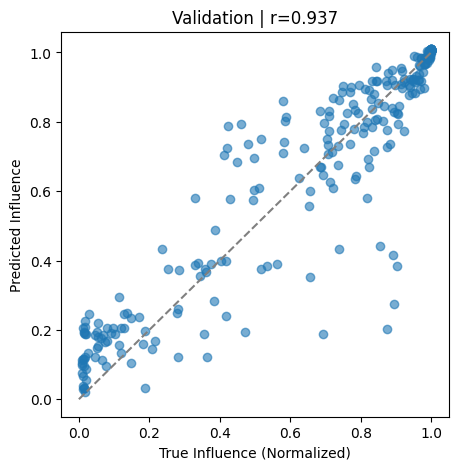

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(trues, preds, alpha=0.6)
plt.xlabel("True Influence (Normalized)")
plt.ylabel("Predicted Influence")
plt.title(f"Validation | r={corr:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.show()


In [19]:
def build_index_map_from_edge_index(edge_index):
    """
    Build mapping from (u,v) -> position in edge_index (0..E*2-1)
    This guarantees perfect alignment with the GNN's expected ordering.
    """
    index_map = {}
    edge_index = edge_index.cpu().numpy()

    for k in range(edge_index.shape[1]):
        u = int(edge_index[0, k])
        v = int(edge_index[1, k])
        index_map[(u, v)] = k

    return index_map

In [20]:
def prepare_edge_mappings(G, data):
    """
    Prepares two maps:
      1) undirected_edge_to_index: (min(u,v), max(u,v)) -> index into w
      2) index_map: (u,v) -> column index in data.edge_index

    G       : networkx.Graph
    data    : torch_geometric.data.Data from from_networkx(G)
    """
    # (1) mapping undirected edges -> index in w
    undirected_edges = [(min(u, v), max(u, v)) for (u, v) in G.edges()]
    undirected_edge_to_index = {e: i for i, e in enumerate(undirected_edges)}

    # (2) mapping directed edges in PyG's edge_index ordering
    index_map = {}
    ei = data.edge_index.cpu().numpy()
    for col in range(ei.shape[1]):
        u = int(ei[0, col])
        v = int(ei[1, col])
        index_map[(u, v)] = col

    return undirected_edge_to_index, index_map

In [21]:
def make_edge_weight(G, w, data, undirected_edge_to_index, index_map):
    """
    Build edge_weight aligned with data.edge_index.

    - w: tensor of shape [num_undirected_edges]
    - edge_weight[k] corresponds to edge_index[:,k].
    """
    E_dir = data.edge_index.size(1)  # number of directed edges
    ew = torch.zeros(E_dir, dtype=torch.float32)

    for (u, v), idx in index_map.items():
        key = (min(u, v), max(u, v))  # undirected key
        ew[idx] = w[undirected_edge_to_index[key]]

    return ew

In [22]:
def apply_relaxation(G, w):
    """Scale edge weights by continuous mask w."""
    A = nx.to_numpy_array(G, dtype=float)
    edges = list(G.edges())
    for k, (i, j) in enumerate(edges):
        A[i, j] *= float(w[k])
        A[j, i] *= float(w[k])
    return A

In [23]:
def build_relaxed_data(G, w):
    data = from_networkx(G)
    data.x = node_features(G)
    data.edge_weight = build_edge_weights(G, w)

    batch = torch.zeros(data.num_nodes, dtype=torch.long)
    return data, batch

In [24]:
def relaxed_data(G, w):
    data = from_networkx(G)
    data.x = node_features(G)

    ew = make_edge_weight(G, w)
    batch = torch.zeros(data.num_nodes, dtype=torch.long)
    return data, ew, batch

In [25]:
def continuous_relaxation_optimize(
    G0,
    model,
    steps=1000,
    lr=0.03,
    lam=0.05,
    thresh=0.5,
    p_ic=0.4,
    sims_ic=600
):
    """
    Perform gradient-based continuous relaxation on graph G0.

    G0      : input networkx.Graph
    model   : trained InfluenceGNN
    steps   : number of gradient steps for w
    lr      : learning rate for w
    lam     : sparsity regularization weight (L1 on w)
    thresh  : threshold to convert w -> hard edge removals
    p_ic    : IC model edge activation probability
    sims_ic : Monte Carlo runs for true influence estimation
    """
    model.eval()

    # --- initial true influence (Monte Carlo) ---
    base_infl = eval_true_influence(G0, p=p_ic, sims=sims_ic)
    print(f"[Init] True influence: {base_infl:.4f}")

    # --- edges and parameter initialization ---
    undirected_edges = [(min(u, v), max(u, v)) for (u, v) in G0.edges()]
    num_edges = len(undirected_edges)

    # Relaxation parameters: one value per undirected edge in [0,1]
    w = torch.full((num_edges,), 0.9, requires_grad=True)

    optimizer = torch.optim.Adam([w], lr=lr)

    # Build static PyG data and mappings (do not depend on w)
    data = from_networkx(G0)
    data.x = node_features(G0)
    batch = torch.zeros(data.num_nodes, dtype=torch.long)

    undirected_edge_to_index, index_map = prepare_edge_mappings(G0, data)

    history = []
    alpha = 1.0
    for step in range(steps):
        optimizer.zero_grad()

        # Build edge weights in edge_index order from current w
        ew = make_edge_weight(G0, w, data, undirected_edge_to_index, index_map)

        # Surrogate prediction
        pred = model(data.x, data.edge_index, batch, edge_weight=ew)

        # Objective: predicted influence + λ * L1(w)
        quad_penalty = alpha * torch.mean((1 - w)**2)
        loss = pred + lam * torch.mean(torch.abs(w)) + quad_penalty

        loss.backward()
        optimizer.step()

        # Keep w in [0,1]
        with torch.no_grad():
            w.clamp_(0.0, 1.0)

        if step % 100 == 0 or step == steps - 1:
            mean_w = float(w.mean().item())
            history.append((step, float(pred.item()), float(loss.item()), mean_w))
            print(
                f"[step {step:4d}] pred={pred.item():.4f} "
                f"loss={loss.item():.4f} mean(w)={mean_w:.4f}"
            )

    # --- Threshold to create pruned graph ---
    w_final = w.detach().clone()
    kept_edges = [e for e, val in zip(undirected_edges, w_final) if val > thresh]

    G_pruned = nx.Graph()
    G_pruned.add_nodes_from(G0.nodes())
    G_pruned.add_edges_from(kept_edges)

    pruned_infl = eval_true_influence(G_pruned, p=p_ic, sims=sims_ic)
    print(f"[Result] Pruned influence: {pruned_infl:.4f}")
    print(f"[Result] Reduction:        {base_infl - pruned_infl:.4f}")
    print(f"[Result] Edges kept:       {len(kept_edges)} / {len(undirected_edges)} = {len(kept_edges) / len(undirected_edges):.4f}%")

    return G_pruned, w_final, history

In [26]:
def discrete_prune(G, w, tau=0.5):
    """Convert continuous mask w into real edge removals."""
    keep_edges = []
    edges = list(G.edges())
    for k, (i, j) in enumerate(edges):
        if w[k] > tau:
            keep_edges.append((i, j))

    Gp = nx.Graph()
    Gp.add_nodes_from(G.nodes())
    Gp.add_edges_from(keep_edges)
    return Gp


def eval_influence(G, p=0.4):
    return monte_carlo_influence(G, p=p, n_sims=600) / G.number_of_nodes()


In [27]:
# === Run continuous relaxation experiment ===

# Pick a synthetic graph for now (safe & in-distribution)
G0 = sample_synthetic()

# baseline influence
orig_inf = eval_influence(G0)
print("Original influence:", orig_inf)

# optimize continuous mask
G_pruned, w_opt, hist = continuous_relaxation_optimize(
    G0,
    model,
    steps=100,
    lr=0.03,
    lam=.3,
    thresh=0.5,
    p_ic=0.4,
    sims_ic=600,
)

# influence after pruning
pruned_inf = eval_influence(G_pruned)
print("Pruned influence:", pruned_inf)

print("Reduction:", orig_inf - pruned_inf)


Original influence: 0.1383816425120773
[Init] True influence: 0.1460
[step    0] pred=0.1593 loss=0.4393 mean(w)=0.8952
[step   99] pred=-0.0788 loss=0.2824 mean(w)=0.7347
[Result] Pruned influence: 0.0587
[Result] Reduction:        0.0873
[Result] Edges kept:       234 / 276 = 0.8478%
Pruned influence: 0.0648792270531401
Reduction: 0.0735024154589372


In [28]:
G = nx.read_edgelist("email-Eu-core.txt.gz", nodetype=int, create_using=nx.Graph())
data = from_networkx(G)
data.x = node_features(G)

model.eval()
with torch.no_grad():
    pred = model(data.x, data.edge_index, torch.zeros(data.num_nodes, dtype=torch.long))
true_influence = monte_carlo_influence(G, p=0.4, n_sims=1000)
true_influence /= G.number_of_nodes()
print("Predicted:", float(pred))
print("True:", true_influence)

Predicted: 0.5965299606323242
True: 0.7926417910447762


In [29]:
vals_true = []
vals_pred = []
perturbed_graphs = []

for _ in range(500):
    Gp = random_perturbation(G)
    perturbed_graphs.append(Gp)
    data = from_networkx(Gp)
    data.x = node_features(Gp)
    batch = torch.zeros(data.num_nodes, dtype=torch.long)

    pred = model(data.x, data.edge_index, batch)
    true = monte_carlo_influence(Gp, p=0.4, n_sims=300) / Gp.number_of_nodes()

    vals_pred.append(float(pred))
    vals_true.append(true)


/tmp/ipykernel_12307/848465164.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  vals_pred.append(float(pred))


In [30]:
from scipy.stats import pearsonr
corr, _ = pearsonr(vals_pred, vals_true)
print("Real-Graph Correlation:", corr)


Real-Graph Correlation: -0.7981695647924915


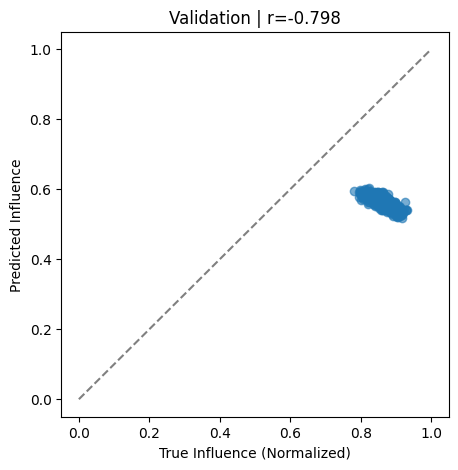

In [31]:
plt.figure(figsize=(5,5))
plt.scatter(vals_true, vals_pred, alpha=0.6)
plt.xlabel("True Influence (Normalized)")
plt.ylabel("Predicted Influence")
plt.title(f"Validation | r={corr:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.show()


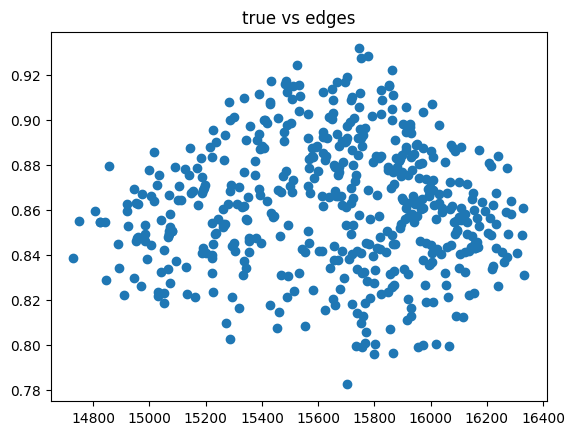

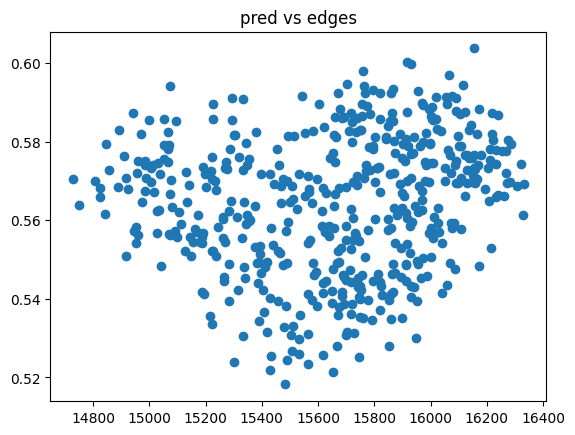

In [32]:
import matplotlib.pyplot as plt

edge_counts = [Gp.number_of_edges() for Gp in perturbed_graphs]
plt.scatter(edge_counts, vals_true); plt.title("true vs edges")
plt.show()
plt.scatter(edge_counts, vals_pred); plt.title("pred vs edges")
plt.show()
